In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
# Reading test and training datasets
train = pd.read_csv('train_titanic.csv')
test = pd.read_csv('test_titanic.csv')

train.index = train['PassengerId']
del train['PassengerId']

test.index = test['PassengerId']
del test['PassengerId']

In [4]:
# Top five line of training dataset
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Removing columns with Name, Ticket and Cabin of datasets
train.drop(['Name', 'Ticket', 'Cabin'], axis = 1, inplace=True)
test.drop(['Name', 'Ticket', 'Cabin'], axis = 1, inplace=True)

In [6]:
new_data_train = pd.get_dummies(train)
new_data_test = pd.get_dummies(test)

In [6]:
# Top five line of test dataset
new_data_test.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
892,3,34.5,0,0,7.8292,0,1,0,1,0
893,3,47.0,1,0,7.0000,1,0,0,0,1
894,2,62.0,0,0,9.6875,0,1,0,1,0
895,3,27.0,0,0,8.6625,0,1,0,0,1
896,3,22.0,1,1,12.2875,1,0,0,0,1


In [7]:
# Top five line of new training dataset
new_data_train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,0,1,0,0,1
2,1,1,38.0,1,0,71.2833,1,0,1,0,0
3,1,3,26.0,0,0,7.9250,1,0,0,0,1
4,1,1,35.0,1,0,53.1000,1,0,0,0,1
5,0,3,35.0,0,0,8.0500,0,1,0,0,1


In [7]:
# Amount of null values in the training set
new_data_train.isnull().sum().sort_values(ascending=False).head(10)

Age           177
Embarked_S      0
Embarked_Q      0
Embarked_C      0
Sex_male        0
Sex_female      0
Fare            0
Parch           0
SibSp           0
Pclass          0
dtype: int64

In [8]:
# Filling null values
new_data_train['Age'].fillna(new_data_train['Age'].mean(), inplace=True)

In [9]:
# Amount of null values in the test dataset
new_data_test.isnull().sum().sort_values(ascending=False).head(10)

Age           86
Fare           1
Embarked_S     0
Embarked_Q     0
Embarked_C     0
Sex_male       0
Sex_female     0
Parch          0
SibSp          0
Pclass         0
dtype: int64

In [10]:
# Filling null values
new_data_test['Fare'].fillna(new_data_train['Fare'].mean(), inplace=True)

In [11]:
# Separating features and targets for model creation
train_features = new_data_train.drop(['Survived'], axis=1) # Features
train_labels = new_data_train['Survived'] # Targets

# Normalization of data train
train_features = (train_features - train_features.mean()) / (train_features.max() - train_features.min())
train_features['Age'].fillna(train_features['Age'].mean(), inplace=True)

# Normalization of data test
test_features = (new_data_test - new_data_test.mean()) / (new_data_test.max() - new_data_test.min()) # Features
test_features['Age'].fillna(test_features['Age'].mean(), inplace=True)

In [12]:
# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.15,
    random_state=10)

In [13]:
# Number of lines of dataset
features_count = train_features.shape[1]
# All the labels
labels_count = 2

tf.reset_default_graph()

# Features and labels tensors
features = tf.placeholder(tf.float32, name="features")
labels = tf.placeholder(tf.float32, name="labels")

# Weights and biases tensors
weights = tf.Variable(tf.truncated_normal((features_count, labels_count)), name="weights")
biases = tf.Variable(tf.zeros([labels_count]), name="biases")

# Feed dicts for training, validation, and test session
train_feed_dict = {features: train_features.as_matrix(), labels: pd.get_dummies(train_labels).as_matrix()}
valid_feed_dict = {features: valid_features.as_matrix(), labels: pd.get_dummies(valid_labels).as_matrix()}
test_feed_dict = {features: test_features.as_matrix(), labels: None}

# Linear Function WX + b
logits = tf.matmul(features, weights) + biases

prediction = tf.nn.softmax(logits)

# Cross entropy
cross_entropy = -tf.reduce_sum(labels * tf.log(prediction), reduction_indices=1)

# Training loss
loss = tf.reduce_mean(cross_entropy)

# Create an operation that initializes all variables
init = tf.global_variables_initializer()

# Determine if the predictions are correct
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
# Calculate the accuracy of the predictions
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

Epoch 200/200 Loss: 0.4254361391067505: 100%|██████████| 4/4 [00:00<00:00, 565.14batches/s]


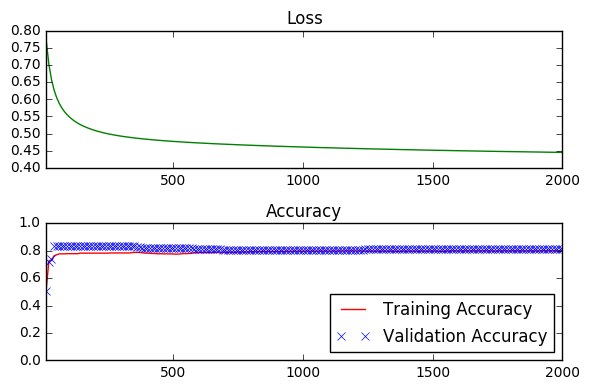

Validation accuracy at 0.8134328126907349


In [14]:
# Trainning neural network

# Change if you have memory restrictions
batch_size = 200

# Find the best parameters for each configuration
epochs = 200
learning_rate = 0.2

# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)    

# The accuracy measured against the validation set
validation_accuracy = 0.0

# Measurements use for graphing loss and accuracy
log_batch_step = 10
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []
v_loss = 0

with tf.Session() as session:
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):     
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{} Loss: {}'.format(epoch_i+1, epochs, v_loss), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size].as_matrix()
            batch_labels = pd.get_dummies(train_labels[batch_start:batch_start + batch_size]).as_matrix()

            # Run optimizer and get loss
            _, v_loss = session.run(
                [optimizer, loss],
                feed_dict={features: batch_features, labels: batch_labels})

            # Log every count batches
            if not batch_i % log_batch_step:
                # Calculate Training and Validation accuracy
                training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
                validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(v_loss)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)

        # Check accuracy against Validation data
        validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)


loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'x', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

print('Validation accuracy at {}'.format(validation_accuracy))

In [15]:
# Generate file to kaggle submission
with tf.Session() as sess:
    sess.run(init)
    indexes = new_data_test.index.values
    test_logits = logits.eval(test_feed_dict)
    predictions = tf.argmax(test_logits, dimension=1).eval()

    with open("submission.csv", "w") as f:
        f.write("PassengerId,Survived\n")
        for index, prediction in zip(indexes, predictions):
            f.write("{0},{1}\n".format(index, prediction))

Instructions for updating:
Use the `axis` argument instead
